# Explainability

This Jupyter notebook details <b>*Integrated gradients*</b>, one of the explainability methods for deep learning frameworks. <br>
The notebook was prepared by <i>Mohammed Amine Gharsallaoui</i>, researcher at BASIRA lab, ITU: http://basira-lab.com/ <br>
You can find other interesting projects in the github reprository of BASIRA: https://github.com/basiralab <br>
The topics covered in this notebook are: <br>
1. Data cleaning <br>
2. model training <br>
3. Integrated gradients in Captum <br>

<b> Resources </b>: <br>
https://arxiv.org/pdf/1703.01365.pdf <br>
https://captum.ai/tutorials/Titanic_Basic_Interpret <br>
https://www.youtube.com/watch?v=9AaDc35JYiI

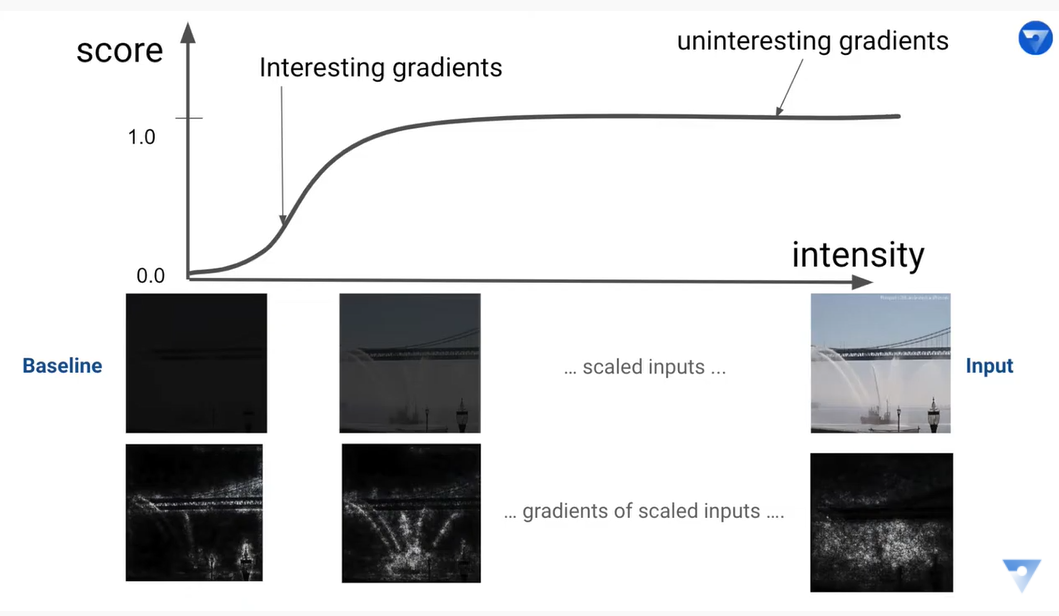

In [1]:
from IPython import display
display.Image("./integrated gradients.png")

Integrated gradients is an attribution method (For example, in an image recognition context, it attributes a model's network to its pixels). Attribution methods are mainly answering the question: why this attribution? with regards to the original features in the input space.

The main idea of the integrated gradients is to explore the features in the input space while integrating along the path from baseline to input (The baseline could be a black image or a random noise).

You start with a baseline and focus on the pixels that affect the perdiction before reaching the saturation phenomenon in deep learning. <b>We are only interested in the area where the score changes.</b>

This is the formula of the integrated gradients: <br>
$IG(input, baseline) = (input - baseline) * \int_{\alpha = 0}^{1} \triangledown F(\alpha * input + (1-\alpha)*baseline)d\alpha$

Along the $i^{th}$ dimension in the input space, the integrated gradients function is computed this way: <br>
$IG_i(input, baseline) = (input_i - baseline_i) * \int_{\alpha =0}^{1} \frac{\partial F(baseline+\alpha\times(input-baseline))}{\partial input_i}d\alpha$

where $F$ is the model's function and $baseline$ is a baseline example depending on the application (for example, in images, a black image would be a baseline).

# Import section

In [2]:
import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import pandas as pd
from captum.attr import IntegratedGradients
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Fix seeds for reproducibility.
np.random.seed(131254)
torch.manual_seed(1)  

# 1. Data processing

In the following dataset, we import the <b>*titanic*</b> dataset.
This dataset contains data for 891 of the real Titanic passengers. Each row represents one person. The columns describe different attributes about the person. The provided features are:<br>
-<b>Survived</b>: Survival (0 = No; 1 = Yes)<br>
-<b>Pclass</b>: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd) (a proxy for socio-economic class)<br>
-<b>Name</b>: Full name<br>
-<b>Sex</b>: Male or female<br>
-<b>Age</b>: Age in years<br>
-<b>SibSp</b>: Number of Siblings/Spouses Aboard<br>
-<b>Parch</b>: Number of Parents/Children Aboard<br>
-<b>Ticket</b>: Ticket Number<br>
-<b>Fare</b>: Passenger Fare (British pound)<br>
-<b>Cabin</b>: Cabin<br>
-<b>Embarked</b>: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [3]:
dataset_path = "titanic.csv"
titanic_data = pd.read_csv(dataset_path)
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Here, we do some data cleaning: <br>
- Remove the irrelevant features. <br>
- Convert the categorical vectors into one-hot encodings. <br>
- Fill the missing values.

In [4]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['Sex']),
                          pd.get_dummies(titanic_data['Embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['Pclass'],prefix="class")], axis=1)
titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].mean())
titanic_data["Fare"] = titanic_data["Fare"].fillna(titanic_data["Fare"].mean())
#titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)
titanic_data = titanic_data.drop(['PassengerId','Name','Ticket','Cabin','Sex','Embarked','Pclass'], axis=1)

In [5]:
titanic_data

,Survived,Age,SibSp,Parch,Fare,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,0,22.000000,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.000000,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.000000,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.000000,0,0,8.0500,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.000000,0,0,13.0000,0,1,0,0,1,0,1,0
887,1,19.000000,0,0,30.0000,1,0,0,0,1,1,0,0
888,0,29.699118,1,2,23.4500,1,0,0,0,1,0,0,1
889,1,26.000000,0,0,30.0000,0,1,1,0,0,1,0,0


In the following cell we separate between features and labels and then convert them into numpy arrays. <br>Next, we split the dataset into training and test sets. 

In [6]:
labels = titanic_data["Survived"].to_numpy()
titanic_data = titanic_data.drop(['Survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

# 2. Model training

Now, we define the neural network used for the task. <br>
The defined neural network has a simple architecture using 2 linear layers: the first with 12 units and the second with 8 units. Each linear layer is followed by a Sigmoid function. <br>The final layer which is followed by a softmax operation has 2 units corresponding to the number of labels in the dataset (survived (1) or not survived (0)).

In [7]:
class SimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In the following cell, we train the model.

In [8]:
net = SimpleNNModel()
criterion = nn.CrossEntropyLoss()
num_epochs = 200

optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)
for epoch in range(num_epochs):    
    output = net(input_tensor)
    loss = criterion(output, label_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

torch.save(net.state_dict(), 'models/titanic_model.pt')

Epoch 1/200 => Loss: 0.70
Epoch 21/200 => Loss: 0.55
Epoch 41/200 => Loss: 0.50
Epoch 61/200 => Loss: 0.48
Epoch 81/200 => Loss: 0.48
Epoch 101/200 => Loss: 0.47
Epoch 121/200 => Loss: 0.47
Epoch 141/200 => Loss: 0.47
Epoch 161/200 => Loss: 0.47
Epoch 181/200 => Loss: 0.47


We display the train accuracy.

In [9]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8378812199036918


We display the test accuracy.

In [10]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.8097014925373134


# 3. Integrated gradients in Captum

Here, we define the <b>*Integrated gradients*</b> object from the Captum library.

In [11]:
ig = IntegratedGradients(net)

Now, we extract the <b>*attributions*</b> (attribution of each feature for the given inputs) and <b>*delta*</b> (approxiamtes the error between the approximated integral and the true integral).
- The approximated integral is computed using a discrete summation of the gradients along the path (from baseline to input).

In [12]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

print(attr.shape)

(268, 12)


Now, we visualize the average attributions of the input features.

Average Feature Importances
Age :  -0.628
SibSp :  -0.055
Parch :  -0.033
Fare :  0.303
female :  0.109
male :  -0.523
embark_C :  0.030
embark_Q :  0.015
embark_S :  0.001
class_1 :  0.152
class_2 :  0.120
class_3 :  -0.156


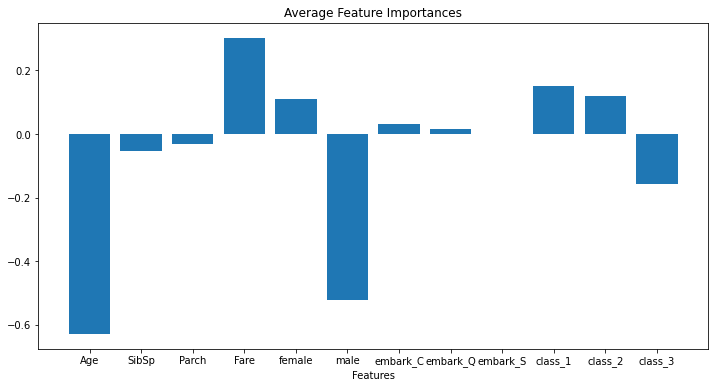

In [13]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

Here, we notice that SibSp feature has a low attribution value. However, it does not mean that this feature has a low importance for all the data entries.

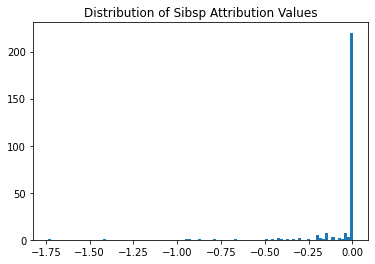

In [14]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");

In the following plot, the size of the dot is proportional to the number of examples with that SibSp value.

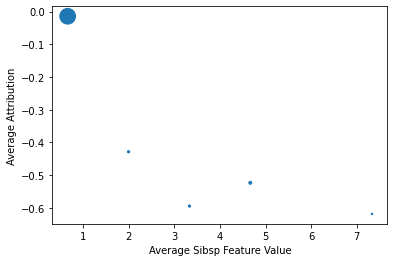

In [15]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");

Thank you!